# Credit Risk Classification

## Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import src.utils as utils

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Load Data

In [3]:
X_TRAIN_PATH = "data/interim/X_train.pkl"
Y_TRAIN_PATH = "data/interim/y_train.pkl"

X_train = utils.deserialize_data(X_TRAIN_PATH)
y_train = utils.deserialize_data(Y_TRAIN_PATH)

display(X_train.head())
display(y_train.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15884,25,241875,MORTGAGE,4.0,EDUCATION,A,16000,7.05,0.07,N,4
15138,21,18000,RENT,5.0,PERSONAL,B,1500,12.18,0.08,N,4
7474,25,53000,MORTGAGE,10.0,MEDICAL,B,16000,12.53,0.30,N,2
18212,28,16800,OWN,NaN,MEDICAL,C,5000,13.98,0.30,N,8
6493,25,50000,MORTGAGE,2.0,VENTURE,A,10000,7.90,0.20,N,2


15884    0
15138    1
7474     0
18212    1
6493     0
Name: loan_status, dtype: int64

In [4]:
num_col = ["person_age", "person_income", "person_emp_length", "loan_amnt",
           "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]
cat_col = ["person_home_ownership", "loan_intent", "cb_person_default_on_file"]

In [5]:
X_train.info()

<class 'pandas.DataFrame'>
Index: 26064 entries, 15884 to 17068
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  26064 non-null  int64  
 1   person_income               26064 non-null  int64  
 2   person_home_ownership       26064 non-null  str    
 3   person_emp_length           25326 non-null  float64
 4   loan_intent                 26064 non-null  str    
 5   loan_grade                  26064 non-null  str    
 6   loan_amnt                   26064 non-null  int64  
 7   loan_int_rate               23563 non-null  float64
 8   loan_percent_income         26064 non-null  float64
 9   cb_person_default_on_file   26064 non-null  str    
 10  cb_person_cred_hist_length  26064 non-null  int64  
dtypes: float64(3), int64(4), str(4)
memory usage: 2.4 MB


Insights:

- There are 7 numeric columns and 4 categorical columns.
- `person_emp_length` and `loan_int_rate` has missing values.

## Exploratory Data Analysis

* [Duplicated Data](#duplicated)
* [Null Values](#null_values)
* [Visualization](#visualization)
* [Summary](#summary)

<a id="duplicated"></a>
### Duplicated Data

In [6]:
X_train.duplicated(keep=False).sum()

np.int64(192)

In [7]:
X_train[X_train.duplicated(keep=False)].sort_values(by="person_income") # type: ignore

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15952,24,7800,RENT,1.0,EDUCATION,B,1000,11.36,0.13,N,4
16821,24,7800,RENT,1.0,EDUCATION,B,1000,11.36,0.13,N,4
2431,21,15600,RENT,0.0,MEDICAL,A,2800,7.40,0.18,N,4
17758,21,15600,RENT,0.0,MEDICAL,A,2800,7.40,0.18,N,4
28295,32,18000,OWN,0.0,VENTURE,A,4750,7.88,0.26,N,6
18261,32,18000,OWN,0.0,VENTURE,A,4750,7.88,0.26,N,6
17642,21,20000,RENT,0.0,MEDICAL,A,2000,NaN,0.10,N,3
16038,26,20000,MORTGAGE,5.0,MEDICAL,A,4800,5.99,0.24,N,3
1778,21,20000,RENT,0.0,MEDICAL,A,2000,NaN,0.10,N,3
591,26,20000,MORTGAGE,5.0,MEDICAL,A,4800,5.99,0.24,N,3


Insights: These identical rows appear to be manual double-entries.

Next action: Dropping all duplicates and retaining only the first occurence.

<a id="null_values"></a>
### Null Values

In [8]:
X_train_null = X_train.isnull().sum()
null_features = X_train_null[X_train_null > 0] # type: ignore

print("Insights:")
for feature, value in null_features.items(): # type: ignore
    dtype = "numeric" if feature in num_col else "categorical"
    print(f"- {feature} is a {dtype} feature, has {value} null values.")

Insights:
- person_emp_length is a numeric feature, has 738 null values.
- loan_int_rate is a numeric feature, has 2501 null values.


Next action: Need to see the data distributions, especially for these two features.

<a id="visualization"></a>
### Visualization

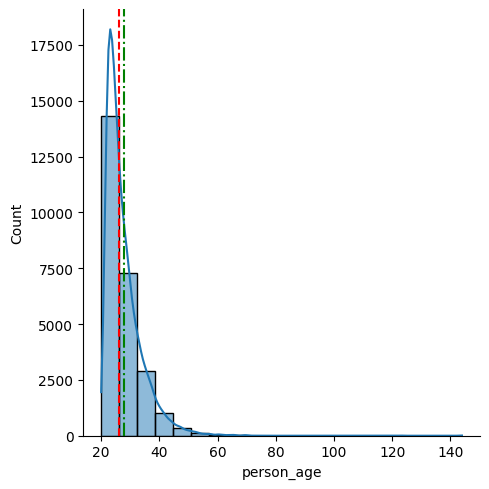

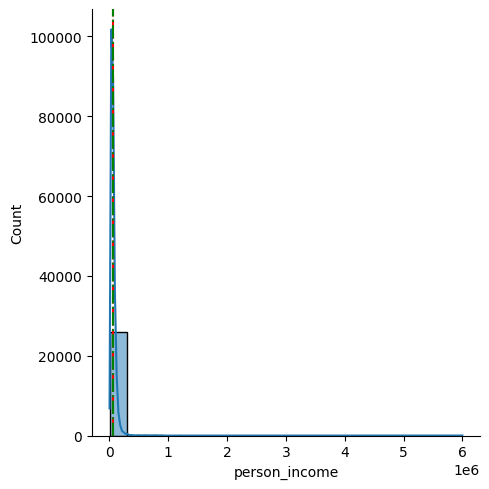

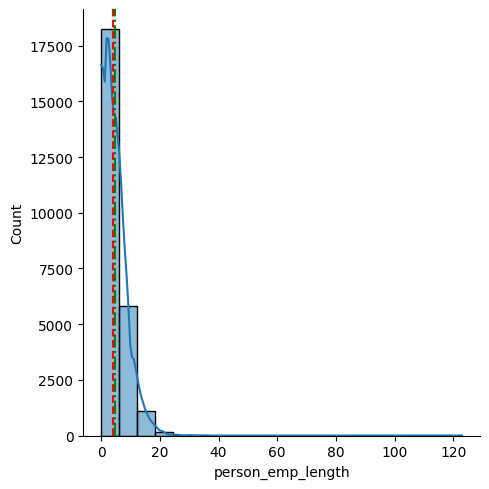

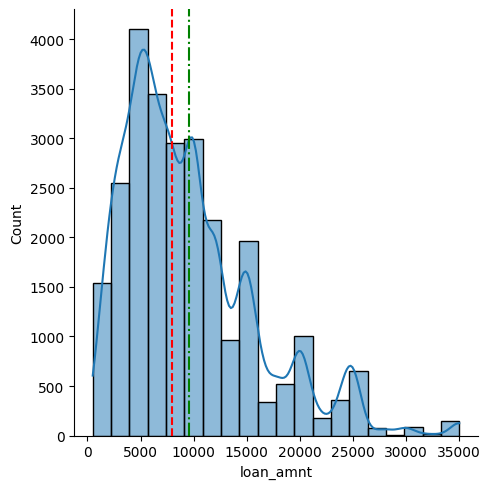

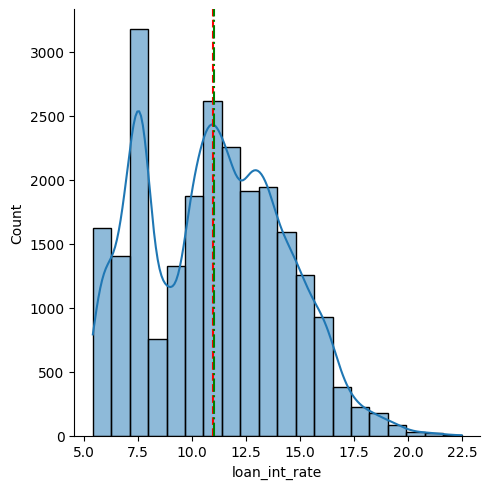

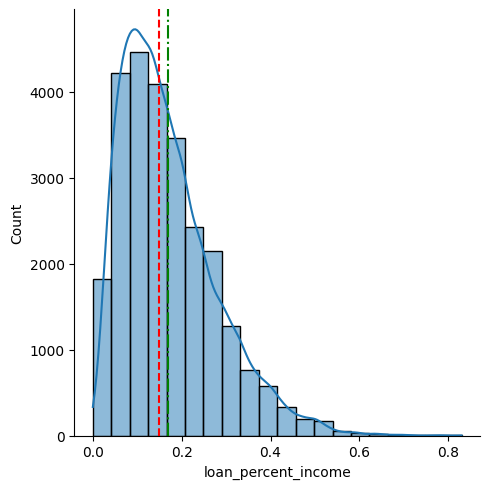

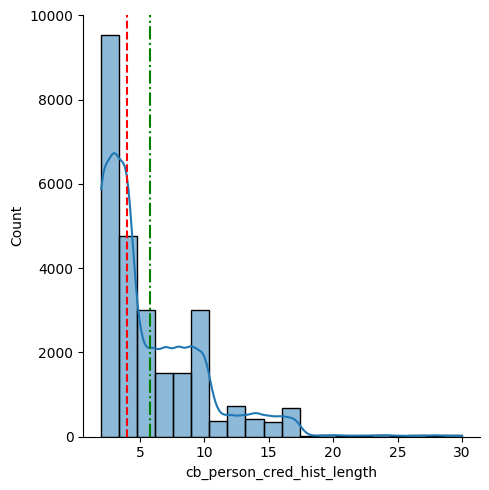

In [9]:
X_train_ = X_train[num_col]

for feature in X_train_.columns: # type: ignore
    sns.displot(data=X_train_, x=feature, kde=True, bins=20) # type: ignore
    median_val = X_train_[feature].median()
    mean_val = X_train_[feature].mean()
    plt.axvline(median_val, color='red', linestyle='--', label=f"Median: {median_val}")
    plt.axvline(mean_val, color='green', linestyle='-.', label=f"Mean: {mean_val}")
    plt.show()

Insights:

Visualization using `displot` and the mean-median comparison provide an initial indication of data symmetry. However, subjective evaluation cannot accurately measure the significance level of distributional deviations. Therefore, statistical tests are necessary to provide an objective basis for decision-making using p-values.

Next action:

Using `normaltest` provided by `scipy.stats`, we'll decide if a feature has normal distribution or not.

In [10]:
from scipy.stats import normaltest

for feature in X_train_.columns: # type: ignore
    data = X_train_[feature].dropna()
    stat, p = normaltest(data)
    print(f"Feature: {feature}")
    print(f"    Statistic: {stat:.3f}, p-value: {p:.3e}")
    if p > 0.05:
        print(f"    {feature} is likely NORMAL distribution.\n")
    else:
        print(f"    {feature} is likely NOT normal (skewed/high kurtosis).\n")

Feature: person_age
    Statistic: 17317.559, p-value: 0.000e+00
    person_age is likely NOT normal (skewed/high kurtosis).

Feature: person_income
    Statistic: 73091.667, p-value: 0.000e+00
    person_income is likely NOT normal (skewed/high kurtosis).

Feature: person_emp_length
    Statistic: 19600.769, p-value: 0.000e+00
    person_emp_length is likely NOT normal (skewed/high kurtosis).

Feature: loan_amnt
    Statistic: 4823.539, p-value: 0.000e+00
    loan_amnt is likely NOT normal (skewed/high kurtosis).

Feature: loan_int_rate
    Statistic: 1342.313, p-value: 3.315e-292
    loan_int_rate is likely NOT normal (skewed/high kurtosis).

Feature: loan_percent_income
    Statistic: 4089.199, p-value: 0.000e+00
    loan_percent_income is likely NOT normal (skewed/high kurtosis).

Feature: cb_person_cred_hist_length
    Statistic: 8414.194, p-value: 0.000e+00
    cb_person_cred_hist_length is likely NOT normal (skewed/high kurtosis).



Insights:

All numerical features exhibit skewed distributions. Consequently, median imputation will be used for all null values instead of the mean to ensure the central tendency is not distorted by outliers.

<Axes: xlabel='loan_status', ylabel='count'>

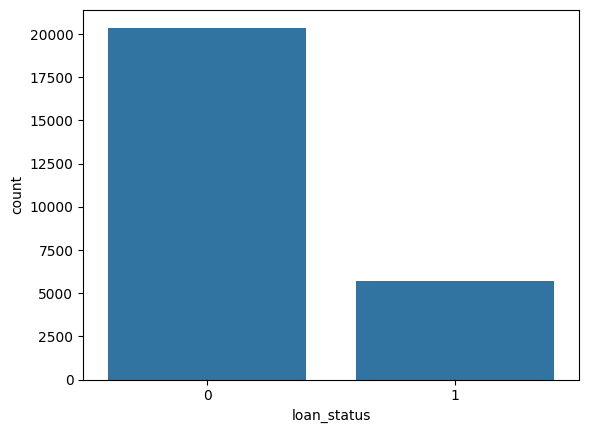

In [11]:
sns.countplot(x=y_train) # type: ignore

Insights:

The target variable exhibits a class imbalance, where the minority class (`loan_status == 1`) is significantly smaller than the majority class (`loan_status == 0`).

Next actions:

To address this imbalance, oversampling techniques such as RandomOverSampler (ROS), SMOTE, or ADASYN will be evaluated to improve the model's ability to detect the minority class.

<a id="summary"></a>
### Summary

* Data integrity: identical rows were identified as manual double-entries. To ensure data quality, all duplicates will be removed, retaining only the occurences.
* Null Value Handling: Significant missing values were found in `person_emp_length` (738) and `loan_int_rate` (2501). Given that all numerical features exhibit skewed distributions, median imputation will be applied to all null values to prevent outliers from distoring the central tendency.
* Class Imbalance: The target variable shows a clear class imbalance, with the minority class being significantly smaller than the majority class.
* Proposed Strategy: to improve the models' sensitivity toward defaults, oversampling techniques, especially RandomOverStrategy, SMOTE, and ADASYN.